In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib as mp
import sklearn
from IPython.display import Image

%matplotlib inline

# Naive Bayes and Support Vector Machines

<P><P><P><P>
<center>

<img src="figs/Thomas_Bayes.gif" alt="Figure" width="38%" align = "left">
<img src="figs/L16-SVM-6.png" alt="Figure" width="40%" align = "right">
    
</center>

<!--- By Unknown author - [2][3], Public Domain, https://commons.wikimedia.org/w/index.php?curid=14532025 --->

Today we'll look at two more very commonly-used, widely-applicable classification methods.

* the _Naive Bayes Classifier_
* the _Support Vector Machine_

## Naive Bayes

The classification problem most generally seeks to associate a label $y$ with a set of features $\mathbf{x}$.  

Perhaps the most fundamental way to attack this problem is via probability.

We'll now consider how to use probability to directly address the classification problem.

A key tool will be __Bayes Rule,__ so let's review that.

### Bayes Rule

We'll start from the definition of conditional probability:

$$ P[A\,|\,C] = \frac{P[A \text{ and } C]}{P[C]} $$

So:

$$ P[A \text{ and } C] = P[A\,|\,C] \cdot P[C]. $$

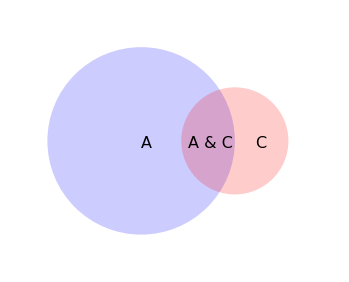

In [2]:
plt.figure(figsize = (6,6))
ax=plt.gcf().gca()
circle = mp.patches.Circle([1, 1], 0.7, facecolor = 'blue', alpha = 0.2)
ax.add_artist(circle)
circle = mp.patches.Circle([1.7, 1], 0.4, facecolor = 'red', alpha = 0.2)
ax.add_artist(circle)
ax.axis('square')
ax.axis('off')
plt.xlim([0, 2.5])
plt.ylim([0, 2])
plt.text(1, .95, 'A', fontsize = 16)
plt.text(1.85, .95, 'C', fontsize = 16)
plt.text(1.35, .95, 'A & C', fontsize = 16);
# plt.title(r'$P[C\,|\,A]\,P[A] = P[A\,|\,C]\,P[C]$'); 

Switching the roles of $A$ and $C$, we can equally say:

$$ P[C \text{ and } A] = P[C\,|\,A] \cdot P[A]. $$

Now $P[C \text{ and } A] = P[A \text{ and } C]$, so:
    
$$ P[A\,|\,C] \cdot P[C] = P[C\,|\,A] \cdot P[A] $$

Rearranging, we get __Bayes' Rule__:
    
$$ P[A\,|\,C] = \frac{P[C\,|\,A] \cdot P[A]}{P[C]}. $$

So there is nothing "magic" about Bayes' Rule: it simply follows from the basic laws of probability.

However, it is __very__ useful!

The reason is that often, $P[A\,|\,C]$ is __not__ known, but the expressions on the right __are__ known.

(We've already seen how this is used in the EM algorithm for Gaussian Mixture Modeling.)

### Using Bayes Rule in a Classifier

Let's start with a simple example:
   * A doctor knows that meningitis causes a stiff neck 75% of the time.
   * This is $P[S\,|\,M]$. 
   
A patient presents with a stiff neck.  What is the probability she has meningitis?

Well, we can't say.  

What we know is $P[S\,|\,M]$, but what we want to know is $P[M\,|\,S]$!

Now perhaps the doctor _also_ knows that 
   * 1 in 20 people in the population have a stiff neck at any given time
       * $P[S] = 1/20$
   * 1 in 10,000 people in the population have meningitis at any given time
       * $P[M] = 1/10000$

   
Now, we can calculate the answer needed:

$$ P[M\,|\,S] = \frac{P[S\,|\,M]}{P[S]}\cdot P[M] = \frac{3/4}{1/20} \cdot 1/10000 = \fbox{$15 \cdot 1/10000$} = 0.0015. $$

I wrote the expressions above that way to point out the essence of Bayesian reasoning:

* A random person has probability 1/10000 of having meningitis
* When __we learn__ that the person has a stiff neck, it __increases their probability__ by a factor of 15.

We give these probabilities names according to their roles:

* The random person's probability (1/10000) is called the __prior__ probability
* The specific patient's probability (15 $\cdot$ 1/10000) is called the __posterior__ probability.

We are going to use this same principle to construct a classifier.

Given a set of items with features and class labels:

The __class label__ will play the role of "meningitis" and the various __attributes__ of the item will play the role of "stiff neck."

We will then ask "how does the value of each feature change the probability of the class label?"

More formally:
    
Consider an item $\mathbf{x}$ having attributes $x_1, x_2, \dots, x_n$.

There are various classes (labels) for items: $C_1, \dots, C_k$.

Our goal is to predict the class of $\mathbf{x}$.


To do that, we will compute $P[C_1\,|\,\mathbf{x}], P[C_2\,|\,\mathbf{x}], \dots, P[C_k\,|\,\mathbf{x}]$.

These form a __soft classification__ of $\mathbf{x}$.

From them, we can form a hard classification.  One way would simply be to choose the class with highest probability.

This is the MAP (_Maximum A Posteriori_) Estimate: 

$$\hat{C} = \arg\max_{\{C_i\}} P[C_i\,|\,\mathbf{x}].$$

Now $P[C_i\,|\,\mathbf{x}] = P[C_i\,|\,x_1, x_2, \dots, x_n]$

How can we approach the problem of computing $P[C_i\,|\,\mathbf{x}]$?

The __key idea__ is that Bayes Rule makes clear that 

$$ P[C_i\,|\,\mathbf{x}] = \frac{P[\mathbf{x}\,|\,C_i]}{P[\mathbf{x}]} \cdot P[C_i] $$

Now, when we vary $C_i$ in the above expression, $P[\mathbf{x}]$ is not changing.

So ... 

The $\hat{C}$ that maximizes 

$$P[C_i\,|\,x_1, x_2, \dots, x_n]$$

is the __same__ as the $\hat{C}$ that maximizes 

$$P[x_1, x_2, \dots, x_n\,|\,C_i]\cdot P[C_i].$$

This gives us an angle of attack on the problem.

The difficult problem that remains is how to estimate

$$ P[x_1, x_2, \dots, x_n\,|\,C_i]. $$

To see the challenge, imagine if we tried to compute $P[x_1, x_2, \dots, x_n\,|\,C_i]$ directly from data. 

Attacking head-on, we could use a histogram to estimate the necessary distribution.  In other words, simply count up how many times we see each combination of feature values.

Let's say there are 20 features ($n = 20$), and 10 possible values for each feature. 

Then for each class $C_i$ we need to construct a histogram with $10^{20}$ bins!   

We would never have enough data to fill all those bins.

The underlying problem we face is the high dimensionality of the feature space.

The size of our histogram is __exponential__ in the number of features.

So, we need to find a way to reduce the exponential size of the estimation problem.

We will do that by __factoring__ the distribution $P[x_1, x_2, \dots, x_n\,|\,C_i]$.

Here is where the "Naive" part comes in.

We will __assume__ that __attributes are independent__ in their assignment to items.

That is, for two sets of attributes, the values of the attributes in one set do not affect the values in the other set.    So all correlations among attributes are zero.

This is indeed a "naive" assumption ... but it can be surprisingly effective in practice.

That implies that:
    
$$ P[x_1, x_2, \dots, x_n\,|\,C_i] = P[x_1\,|\,C_i] \cdot P[x_2\,|\,C_i] \cdot \dots P[x_n\,|\,C_i]  $$

This is very helpful computationally, because the factors $P[x_j\,|\,C_i]$ are individually much lower-dimensional than the full distribution.

In a naive Bayes model, the quantity we calculate for each class $C_i$ is

$$ \left(P[x_1\,|\,C_i] \cdot P[x_2\,|\,C_i] \cdot \dots P[x_n\,|\,C_i]\right) \cdot P[C_i] $$

You can see each conditional probability as a "correction factor" to $P[C_i]$.

Each factor $P[x_j\,|\,C_i]$ tells us how we should update our confidence in $C_i$ based on the value of a particular feature $x_j$.

So, what remains then is to estimate $P[x_j\,|\,C_i]$ for all $x_j$ and $C_i$.

We will estimate these quantities from our training data.

To summarize the steps of Naive Bayes:

__Training__

* Compute all the per-class attribute probabilities $P[x_j\,|\,C_i]$ from training data.
* Compute all the class probabilities $P[C_i]$ from the training data.

__Predicting__

* For a given item $\mathbf{x} = (x_1, x_2, \dots, x_n)$, 
    * For each class $C_i,$ compute $P[x_1\,|\,C_i] \cdot P[x_2\,|\,C_i] \cdot \dots P[x_n\,|\,C_i] \cdot P[C_i]$
    * For a hard classification, return the class that maximizes the above expression.
        * That is, the MAP estimate.

### Computing Attribute Probabilities from Data

All that remains is to compute the conditional attribute probabilities from data.

The strategy depends on the attribute type: __discrete__ or __continuous.__

<center>
    
<img src="figs/L16-sample-data.png" alt="Figure" width="40%">
    
</center>

__Discrete Attributes__.

Discrete attributes, such as categorical or ordinal attributes, can be handled via histograms.

In the above table, to handle the <font color = "blue"> Marital Status </font> attribute for the <font color = "blue"> $\text{Evade} = \text{No}$ </font> class,  we need to compute

$$ P[\text{Single}\,|\,\text{Evade }=\text{ No}] = 2 / 7 = 0.29 $$

and

$$ P[\text{Married}\,|\,\text{Evade }=\text{ No}] = 4 / 7 = 0.57 $$

and

$$ P[\text{Divorced}\,|\,\text{Evade }=\text{ No}] = 1 / 7 = 0.14 $$

One problem that can arise is when a histogram bin has zero entries.  Then the conditional probability for this attribute value is zero, which overrides all the other factors and yields a zero probability.

There are various strategies for making small corrections to the counts that avoid this problem.

<center>
    
<img src="figs/L16-sample-data.png" alt="Figure" width="40%">
    
</center>

__Continuous Attributes.__

Continuous attributes can be handled via histograms as well, by binning up the values.   

In the above example, we could create bins to hold ranges of values for <font color = "blue"> Taxable Income </font>.

However, another commonly used approach is to assume that the data follow a parametric probability distribution.

Most often the Gaussian is used (of course).

So we might form conditional probabilities for <font color = "blue"> Taxable Income </font> as

$$ P[\text{Taxable Income} = x\,|\,\text{Evade }=\text{ No}] = \mathcal{N}(x; \mu_\text{No}, \sigma_\text{No}) $$

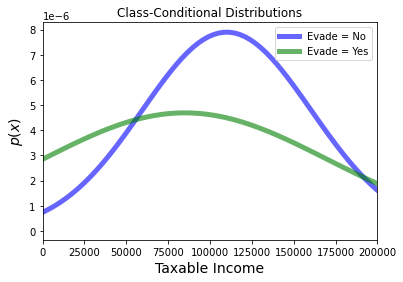

In [3]:
from scipy.stats import norm
eno = np.array([125000, 100000, 70000, 120000, 60000, 220000, 75000])
eyes = np.array([95000, 85000, 75000])
mu_no = np.mean(eno)
sig_no = np.std(eno)
mu_yes = np.mean(eyes)
sig_yes = np.mean(eyes)
plt.figure()
x = np.linspace(norm.ppf(0.001, loc = mu_no, scale = sig_no), norm.ppf(0.999, loc = mu_no, scale = sig_no), 100)
plt.plot(x, norm.pdf(x, loc = mu_no, scale = sig_no),'b-', lw = 5, alpha = 0.6, label = 'Evade = No')
x = np.linspace(norm.ppf(0.001, loc = mu_yes, scale = sig_yes), norm.ppf(0.999, loc = mu_yes, scale = sig_yes), 100)
plt.plot(x, norm.pdf(x, loc = mu_yes, scale = sig_yes),'g-', lw = 5, alpha = 0.6, label = 'Evade = Yes')
plt.xlim([0, 200000])
plt.xlabel('Taxable Income', size=14)
plt.legend(loc = 'best')
plt.title('Class-Conditional Distributions')
plt.ylabel(r'$p(x)$', size=14);

In summary:
    
* Naive Bayes attacks the classification problem through probability, 
    * which is perhaps the most natural formal tool for the problem.
* Training is very simple, based on estimating class-conditional histograms or parametric densities of features.
* Naive Bayes can work well in high-dimensional settings (many features) 
    * Many times the correct label is the MAP estimate, even if individual probabilities are less accurate.
* Its principal drawback is its assumption of __independence__ among the features.

## Support Vector Machines

We now turn to the support vector machine (SVM).  

The SVM is based on explicit __geometric__ considerations about how best to build a classifier.

As an example, here is a set of training data, considered as points in $\mathbb{R}^d$:

<center>
    
<img src="figs/L16-SVM-1.png" alt="Figure" width="40%">
    
</center>

We will start with the idea of a __linear separator__.

This is a hyperplane that forms a decision boundary.

Here is one possible separator:

<center>
    
<img src="figs/L16-SVM-2.png" alt="Figure" width="40%">
    
</center>

Here is another possible separator:

<center>
    
<img src="figs/L16-SVM-3.png" alt="Figure" width="40%">
    
</center>

Which separator is __better__?

Well, they both perfectly separate the two classes in the training data.

<center>
    
<img src="figs/L16-SVM-4.png" alt="Figure" width="40%">
    
</center>

But what we really care about is accuracy on the test data -- __generalization__ ability.

It seems that $B_1$ is a better choice, because it is __farther__ from __both__ classes.

So, new data falling in the region between training classes is more likely to be correctly classified by $B_1$.

This leads to a principle for choosing the best separator:
    
* We are concerned with the __margin__ between the separator and the data, and
* We prefer the separator that __maximizes the margin__.

In fact, there are theoretical results suggesting that this is an optimal strategy for choosing a separator that has good generalization ability.

<center>
    
<img src="figs/L16-SVM-5.png" alt="Figure" width="40%">
    
</center>

### Linear SVM: Separable Case

Let's see how we can train an SVM.

As usual, our training data consists of tuples $(\mathbf{x}_i, y_i)$, where $\mathbf{x}_i \in \mathbb{R}^d$, and (by convention) $y_i \in \{-1, 1\}$.

We're going to assume (for now) that our data can be perfectly separated by a hyperplane.

Any hyperplane (such as $B_1$ below) can be written as:

$$ w_1 x_1 + w_2 x_2 + \dots + w_d x_d + b = 0$$

or more concisely:

$$ \mathbf{w}^T\mathbf{x} + b = 0. $$

So our decision boundary (ie, our classifier) has parameters $\{w_i\}$ and $b$.

<center>
    
<img src="figs/L16-SVM-5.png" alt="Figure" width="40%">
    
</center>

For any $\mathbf{x}_+$ from the positive class (circle) located __above__ the decision boundary, 

$$ \mathbf{w}^T\mathbf{x}_+ + b = k $$

for some __positive__ $k$.

<center>
    
<img src="figs/L16-SVM-6.png" alt="Figure" width="40%">
    
</center>


Likewise for any $\mathbf{x}_-$ from the negative class (square) located __below__ the decision boundary, 

$$ \mathbf{w}^T\mathbf{x}_- + b = -k $$

for the same $k$.

We'll rescale the parameters $\mathbf{w}$ and $b$ by dividing through by $k$, thus obtaining new equations for the __same__ hyperplanes:

$$ b_{11}: \mathbf{w}^T\mathbf{x}_+ + b = 1 $$
$$ b_{12}: \mathbf{w}^T\mathbf{x}_- + b = -1 $$

How far apart are these hyperplanes?

The vector $\mathbf{w}$ is orthogonal to the hyperplanes $b_{11}$ and $b_{12}$.

So the distance between the two hyperplanes is the component of $(\mathbf{x}_+ - \mathbf{x}_-)$ that is in the direction of $\mathbf{w}$.

In other words, the projection of $(\mathbf{x}_+ - \mathbf{x}_-)$ onto $\mathbf{w}$.

Which is given by $$d = \frac{\mathbf{w}^T}{\Vert\mathbf{w}\Vert}(\mathbf{x}_+ - \mathbf{x}_-).$$

But subtracting the equations for the hyperplanes, we get:

$$ \mathbf{w}^T(\mathbf{x}_+ - \mathbf{x}_-) = 2 $$

So we conclude:

$$ d = \frac{2}{\Vert\mathbf{w}\Vert}. $$

Now, we have a measure for how good a separator is in terms of its parameters $\mathbf{w}$.

We want the separator to maximize $ d = \frac{2}{\Vert\mathbf{w}\Vert},$ or equivalently, minimize $ \Vert\mathbf{w}\Vert$.

What separators should we consider (ie, search through)?

The answer is, we consider all separators that correctly classify each point.

That is, for all training points ($\mathbf{x}_i, y_i)$:
    
$$ \mathbf{w}^T\mathbf{x}_i + b \ge 1 \text{ if } y_i = 1 $$

and 

$$ \mathbf{w}^T\mathbf{x}_i + b \le -1 \text{ if } y_i = -1 $$

So now we can formally state the problem of defining the __maximum margin separator__:

$$ \mathbf{w}^* = \arg\min_\mathbf{w} \Vert\mathbf{w}\Vert$$

Subject to:

$$ \mathbf{w}^T\mathbf{x}_i + b \ge 1 \text{ if } y_i = 1 $$

$$ \mathbf{w}^T\mathbf{x}_i + b \le -1 \text{ if } y_i = -1 $$

This is a __constrained obtimization problem__ with a __quadratic objective function.__

The quadratic form $\Vert \mathbf{w}\Vert$ is positive definite, so it is strictly convex (it has a unique global minimum).

Such problems are called <font color = "blue">quadratic programs.</font>   

There are standard methods for solving them.   The methods are effective but can be slow.

The complexity of the problem grows with the number of constraints (ie, the number of training points).

Ultimately, only a subset of the training points (constraints) will determine the final solution.

The points that determine the solution "support" it.  They are the __support vectors.__

<center>
    
<img src="figs/L16-SVM-6.png" alt="Figure" width="40%">
    
</center>

### Linear SVM: Non-Separable Case

It may well happen that there is no hyperplane that perfectly separates the classes.

<center>
    
<img src="figs/L16-SVM-7.png" alt="Figure" width="40%">
    
</center>

In this case, we allow points to fall on the "wrong" side of their separator, but we add a penalty for this occurrence.

To express this formally, we introduce __slack__ variables, one per data point: $\xi_i$.   

Each $\xi_i$ measures how far the data point is on the "wrong side" of its separator.

So the constraints are loosened:

$$ \mathbf{w}^T\mathbf{x}_i + b \ge 1-\xi_i \text{ if } y_i = 1 $$

$$ \mathbf{w}^T\mathbf{x}_i + b \le -1+\xi_i \text{ if } y_i = -1 $$

$$ \xi_i \ge 0.$$

And the new problem is:

$$ \mathbf{w}^* = \arg\min_\mathbf{w} \left(\Vert\mathbf{w}\Vert + C (\sum_{i=1}^N \xi_i)^k\right),$$

subject to the above constraints.

Notice we have introduced a hyperparameter: $C$.
    
$C$ essentially controls the complexity of the SVM.  

Hence it needs to be set by cross-validation.

A small value of $C$ will result in allowing many points to fall on the wrong side of their corresponding hyperplane (having a nonzero $\xi_i$) resulting in a large number of support vectors.   So small $C$ results in a more stable decision boundary.

Large $C$ values will penalize violations heavily, and will result in fewer nonzero $\xi_i$s, leading to fewer support vectors.

### Nonlinear SVM

Finally, we consider the case in which the decision boundary is strongly nonlinear.


<center>
    
<img src="figs/L16-SVM-8.png" alt="Figure" width="40%">
    
</center>

The basic idea here is that we take the data and transform it into another, higher-dimensional space.

Here is the same dataset on transformed coordinates:

$$ x_1 \rightarrow x_1 $$

$$ x_2 \rightarrow (x_1 + x_2)^4 $$

<center>
    
<img src="figs/L16-SVM-9.png" alt="Figure" width="40%">
    
</center>

(We are not showing more dimensions here, but the principle is the same.)

In the higher dimensional space, the points may be (approximately) separable.

To achieve this using the framework of the SVM, we use a __kernel__.

A kernel is a similarity function $K(\mathbf{x}, \mathbf{y})$.

There are many ways to define kernels. 

The most popular kernels are:
    
* Linear (aka Inner Product): $K(\mathbf{x}, \mathbf{y}) = \mathbf{x}^T\mathbf{y}$
* Polynomial: $K(\mathbf{x}, \mathbf{y}) = (\mathbf{x}^T\mathbf{y})^d$
* Gaussian: $K(\mathbf{x}, \mathbf{y}) = \text{exp}(-\gamma\Vert\mathbf{x}-\mathbf{y}\Vert^2)$

The Gaussian kernel is also called a "Radial Basis Function".   

There is an efficient way to train an SVM using a kernel for a similarity function.

The basic idea is that the standard linear SVM is trained using Euclidean distance.

However, the squared Euclidean distance between two vectors is:
    
$$ \Vert\mathbf{x} - \mathbf{y}\Vert^2 = (\mathbf{x} - \mathbf{y})^T(\mathbf{x} - \mathbf{y}) = \mathbf{x}^T\mathbf{x} + \mathbf{y}^T\mathbf{y} - 2\mathbf{x}^T\mathbf{y}$$

So the Euclidean distance can be defined entirely in terms of the __inner product__ kernel!

To train an SVM with a different kernel, we just replace all the inner products with calls to our new kernel function. 

The result is that we can obtain highly curved decision boundaries (we'll demonstrate next).

In practice, RBF works well in many cases.

### SVM: Summary

* In practice, SVMs have shown good results on many problems.

* In particular, it is effective at dealing with high-dimensional data and avoids the curse of dimensionality.

* Since all data is represented as vectors, and we are relying on distance functions like Euclidean distance, it is important to pay attention to feature scaling when using SVMs.

## SVM and Naive Bayes in Python

We work with a dataset describing Italian wine samples (https://archive.ics.uci.edu/ml/datasets/Wine). 

We will take the alcohol content of the wine, and its Malic acid content, and use it to predict the grape type (cultivar).

In [23]:
import sklearn.utils as utils
import sklearn.svm as svm
import sklearn.model_selection as model_selection
import sklearn.datasets as datasets

In [24]:
wine = pd.read_table("data/wine.data", sep=',')

wine.columns = [
            'region',
            'Alcohol',
            'Malic acid',
            'Ash',
            'Alcalinity of ash',
            'Magnesium',
            'Total phenols',
            'Flavanoids',
            'Nonflavanoid phenols',
            'Proanthocyanins',
            'Color intensity',
            'Hue',
            'OD280/OD315 of diluted wines',
            'Proline']

X = wine[['Alcohol', 'Malic acid']].values
y = wine['region'].values

We'll first fit a linear SVM to the data:

In [25]:
np.random.seed(0)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, 
                                                                    y, 
                                                                    test_size = 0.5)

In [26]:
svc = svm.SVC(kernel = 'linear')
svc.fit(X_train, y_train)
y_pred_test = svc.predict(X_test)
print(f'Accuracy of SVM on test set: {svc.score(X_test, y_test):0.3f}')

Accuracy of SVM on test set: 0.764


Let's visualize the decision boundaries:

In [27]:
from matplotlib.colors import ListedColormap
# Create color maps for 3-class classification problem, as with iris
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

def plot_estimator(estimator, X, y):
    
    try:
        X, y = X.values, y.values
    except AttributeError:
        pass
    
    estimator.fit(X, y)
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light, shading='auto')

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
    plt.axis('tight')
    # plt.axis('off')
    plt.tight_layout()

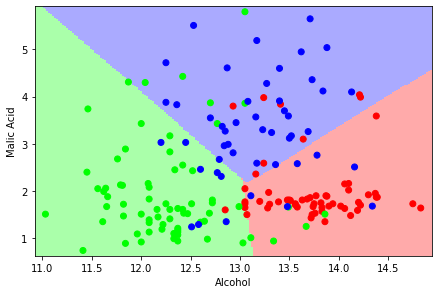

In [28]:
plot_estimator(svc, X, y)
plt.xlabel('Alcohol')
plt.ylabel('Malic Acid');

Note that in practice we should pay attention to feature scaling when using SVMs.  We haven't done that here.

As described already, the SVM gets its name from the samples in the dataset from each class that lie closest to the other class. 

These training samples are called "support vectors" because changing their position in the $d$-dimensional feature space would change the location of the decision boundary.

In `scikit-learn`, the indices of the support vectors for each class can be found in the `support_vectors_` attribute of the SVC object. 

Here, we will use just two of the three classes for clarity. 

The support vectors are circled.   Can you visualize the two separator hyperplanes?

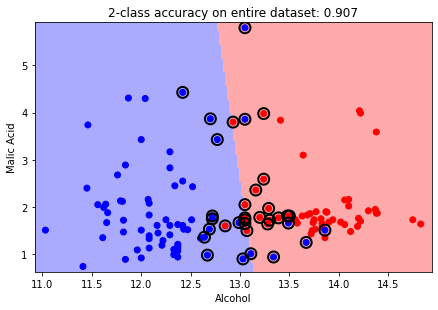

In [29]:
# Extract classes 1 and 2
X, y = X[np.in1d(y, [1, 2])], y[np.in1d(y, [1, 2])]

plot_estimator(svc, X, y)
plt.xlabel('Alcohol')
plt.ylabel('Malic Acid')
plt.scatter(svc.support_vectors_[:, 0], 
           svc.support_vectors_[:, 1], 
           s=120, 
           facecolors='none', 
           edgecolors = 'k',
           linewidths=2,
           zorder=10);
plt.title(f'2-class accuracy on entire dataset: {svc.score(X, y):0.3f}');

### Regularization

Since the classes are not linearly separable, there are nonzero slack variables, each of which is associated with a support vector.

Therefore we should consider how regularization is tuned via the $C$ parameter. 

In practice, a large $C$ value means that the number of support vectors is small (less regularization, more model complexity), while a small $C$ implies many support vectors (more regularization, less model complexity). 

`scikit-learn` sets a default value of $C=1$.

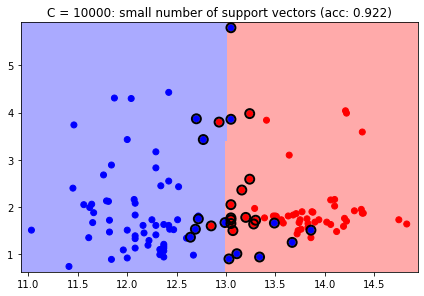

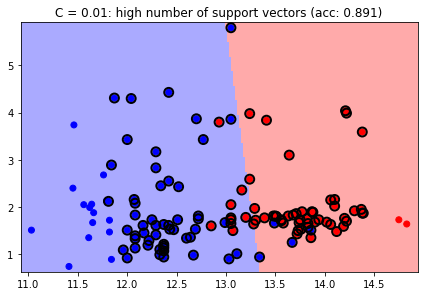

In [30]:
svc = svm.SVC(kernel='linear', C=1e4)
plot_estimator(svc, X, y)
plt.scatter(svc.support_vectors_[:, 0], svc.support_vectors_[:, 1], s=80, 
            facecolors='none', edgecolors = 'k', linewidths=2, zorder=10)
plt.title(f'C = 10000: small number of support vectors (acc: {svc.score(X, y):0.3f})');

svc = svm.SVC(kernel='linear', C=1e-2)
plot_estimator(svc, X, y)
plt.scatter(svc.support_vectors_[:, 0], svc.support_vectors_[:, 1], s=80, 
            facecolors='none', edgecolors = 'k', linewidths=2, zorder=10)
plt.title(f'C = 0.01: high number of support vectors (acc: {svc.score(X, y):0.3f})');

### Kernels

We can also choose from a suite of available kernels:

* linear, 
* poly, 
* rbf, 
* sigmoid, or 
* precomputed.

Or, a custom kernel can be passed as a function. 

Note that the radial basis function (rbf) kernel is just a Gaussian kernel, but with parameter $\gamma = \frac{1}{\sigma^2}$.

__Linear Kernel__

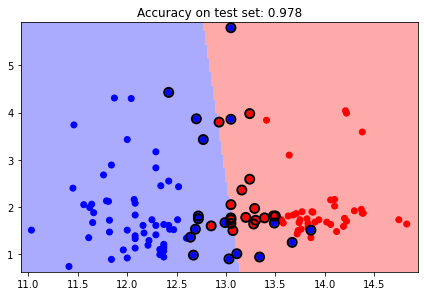

In [31]:
svc_lin = svm.SVC(kernel = 'linear')
plot_estimator(svc_lin, X, y)
plt.scatter(svc_lin.support_vectors_[:, 0], svc_lin.support_vectors_[:, 1], 
            s=80, facecolors='none', edgecolors = 'k', linewidths=2, zorder=10)
plt.title('Linear kernel')
y_pred_test = svc_lin.predict(X_test)
plt.title(f'Accuracy on test set: {svc.score(X_test, y_pred_test):0.3f}');

__Polynomial Kernel__

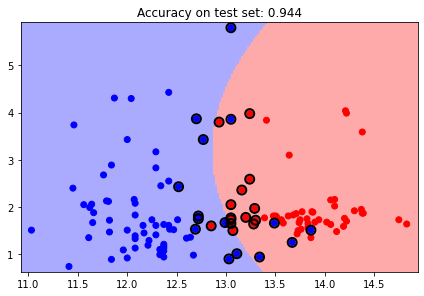

In [32]:
svc_poly = svm.SVC(kernel='poly', degree=4)
plot_estimator(svc_poly, X, y)
plt.scatter(svc_poly.support_vectors_[:, 0], svc_poly.support_vectors_[:, 1], 
           s=80, facecolors='none', edgecolors = 'k', linewidths=2, zorder=10)
plt.title('Polynomial kernel')
y_pred_test = svc_poly.predict(X_test)
plt.title(f'Accuracy on test set: {svc.score(X_test, y_pred_test):0.3f}');

__RBF kernel__

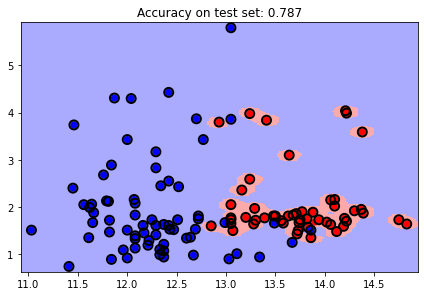

In [41]:
svc_rbf = svm.SVC(kernel='rbf', gamma=100, C = 1e2)
plot_estimator(svc_rbf, X, y)
plt.scatter(svc_rbf.support_vectors_[:, 0], svc_rbf.support_vectors_[:, 1], 
           s=80, facecolors='none', edgecolors = 'k', linewidths=2, zorder=10)
plt.title('RBF kernel')
y_pred_test = svc_rbf.predict(X_test)
plt.title(f'Accuracy on test set: {svc.score(X_test, y_pred_test):0.3f}');

### Cross-Validation

Let's evaluate our choice of hyperparameter $C$.

We have seen how to tune hyperparameters already using `model_selection.train_test_split()`.

Now we'll use a utility `model_selection.cross_val_score()` which will do $k$-fold cross validation for us, for a single hyperparmeter setting, automatically:

In [15]:
f = svm.SVC(kernel = 'linear', C = 1)
scores = model_selection.cross_val_score(f, 
                                         wine[['Alcohol', 'Malic acid']], 
                                         wine['region'], 
                                         cv = 5)

print(f'Scores: {scores}')
print(f'Accuracy: {scores.mean():0.2f} (+/- {scores.std()/np.sqrt(5):0.2f})')

Scores: [0.69444444 0.80555556 0.82857143 0.74285714 0.68571429]
Accuracy: 0.75 (+/- 0.03)


Let's use this to do a grid search to tune $C$:

In [16]:
means = []
stds = []
folds = 5
C_vals = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
for C_val in C_vals:
    f = svm.SVC(kernel='linear', C = C_val)
    scores = model_selection.cross_val_score(f, wine[['Alcohol', 'Malic acid']], wine['region'], cv = folds)
    means.append(np.mean(scores))
    stds.append(np.std(scores) / np.sqrt(folds))
acc = np.array(means)
stderr = np.array(stds)
C_s = np.array(C_vals)

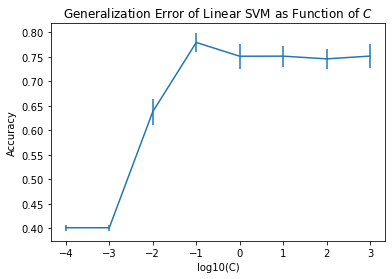

In [17]:
plt.errorbar(np.log10(C_vals), acc, stderr)
plt.xlabel('log10(C)')
plt.ylabel('Accuracy')
plt.title(r'Generalization Error of Linear SVM as Function of $C$');

### SVM and NB: the Iris Data

To compare SVM and Naive Bayes, we'll look at the Iris dataset again, and just using two features for visualization.

We will not hold out data since we're just interested in the shapes of the decision boundaries.

In [18]:
iris = datasets.load_iris()
X = iris.data[:, :2]                     
y = iris.target

In [19]:
C = 1.0  

svc = svm.SVC(kernel = 'linear', C = C).fit(X, y)
rbf_svc = svm.SVC(kernel = 'rbf', gamma = 0.7, C = C).fit(X, y)
poly_svc = svm.SVC(kernel = 'poly', degree = 3, C = C).fit(X, y)

To use Naive Bayes "out of the box", one has to treat all the features as either:
* Gaussian
* Multinomial (Categorical)
* Binary

`scikit-learn` provides a Naive Bayes classifier for each of these cases.

We'll use the Gaussian.

In [20]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB().fit(X, y)

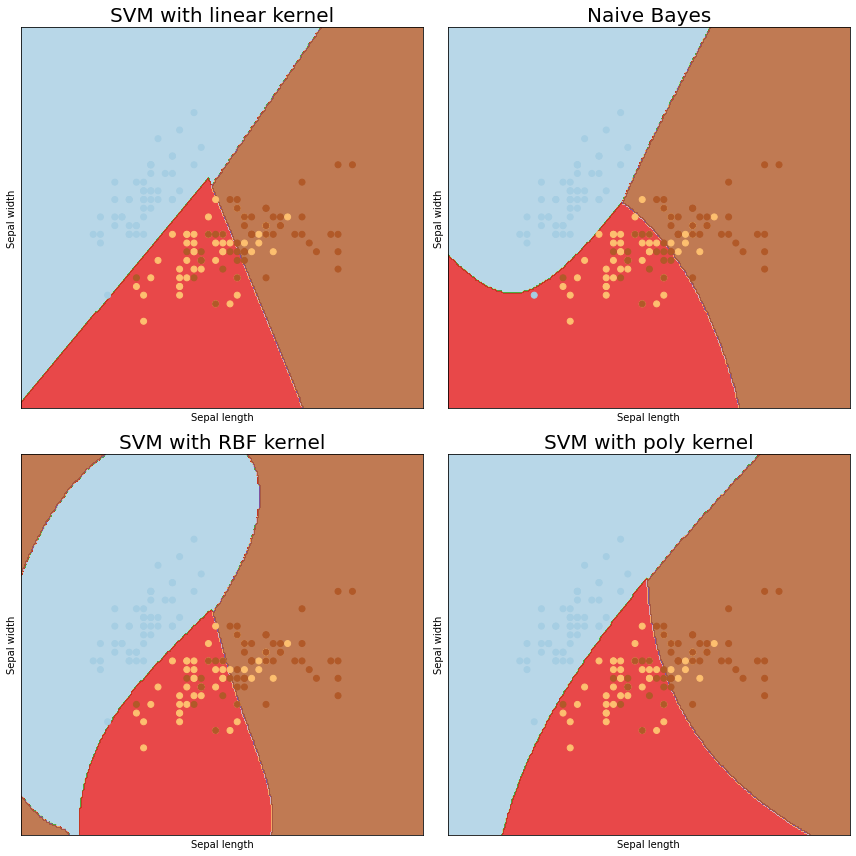

In [21]:
# create a mesh to plot in
h = .02  # step size in the mesh
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# title for the plots
titles = ['SVM with linear kernel',
          'Naive Bayes',
          'SVM with RBF kernel', 'SVM with poly kernel']

fig = plt.figure(figsize=(12,12))

for i, clf in enumerate((svc, gnb, rbf_svc, poly_svc)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    plt.subplot(2, 2, i + 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
    plt.xlabel('Sepal length')
    plt.ylabel('Sepal width')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[i], size = 20)

plt.tight_layout()